**Name of the project:**
Dutch TTF Natural Gas Analysis 

Conducted by:

Richard Imre Toth

**Senior Business Data Analyst**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Jupyter and Python are working, all good!")

Jupyter and Python are working, all good!


In [2]:
file_path = "ICE Dutch TTF Natural Gas Futures Historical Data.csv"
df = pd.read_csv(file_path)

**Data cleaning and pre-processing**

In [3]:
import numpy as np

# Date transformation
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Convert number fields to float (removing commas)
for col in ['Close', 'Open', 'High', 'Low']:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)

# Cleaning the Volume column (pl. 116.16K -> 116160)
def parse_volume(v):
    if pd.isna(v):
        return np.nan
    s = str(v).replace(',', '').strip()
    if s.endswith('K') or s.endswith('k'):
        return float(s[:-1]) * 1000
    elif s.endswith('M') or s.endswith('m'):
        return float(s[:-1]) * 1_000_000
    else:
        return float(s)

df['Volume'] = df['Vol.'].apply(parse_volume)

# Change % cleaning
df['Change_pct'] = df['Change %'].astype(str).str.replace('%', '').astype(float)

# Drop the unnecessary columns
df = df.drop(columns=['Vol.', 'Change %'])

# Controlling data types
df.dtypes

Date          datetime64[ns]
Close                float64
Open                 float64
High                 float64
Low                  float64
Volume               float64
Change_pct           float64
dtype: object

In [4]:
# Checking the time series continuity

# Sorting by date (in case it is not already sorted)
df = df.sort_values('Date').reset_index(drop=True)

# Calculating the difference between adjacent dates
df['Date_diff'] = df['Date'].diff()

# Checking what date intervals there are
date_gaps = df['Date_diff'].value_counts().sort_index()
print("Frequency of date intervals (in days):")
print(date_gaps)

# Checking for missing data (e.g., greater than 1 day)
missing_gaps = df[df['Date_diff'] > pd.Timedelta(days=1)]
print(f"\nNumber of missing dates: {len(missing_gaps)}")

# If there is a gap, please show the first few
if len(missing_gaps) > 0:
    print("\nExamples of missing dates:")
    print(missing_gaps[['Date', 'Date_diff']].head())
else:
    print("\nThe time series is complete, there are no missing days.")

# It also shows the dates of the last 5 rows for the verification/check
print("\nDate range:", df['Date'].min().strftime('%Y-%m-%d'), "→", df['Date'].max().strftime('%Y-%m-%d'))

Frequency of date intervals (in days):
Date_diff
1 days    958
2 days      1
3 days    236
4 days      3
5 days      5
Name: count, dtype: int64

Number of missing dates: 245

Examples of missing dates:
         Date Date_diff
5  2021-01-11    3 days
10 2021-01-18    3 days
15 2021-01-25    3 days
20 2021-02-01    3 days
25 2021-02-08    3 days

Date range: 2021-01-04 → 2025-09-05



**Data cleaning and time series completeness check – interpretation**

The data file contains the Dutch TTF natural gas exchange prices for the period between January 4, 2021, and September 5, 2025. Based on the time series check:

Most dates have a 1-day difference, indicating daily trading data.

3-day gaps occur regularly, which signify weekends when the exchange is closed.

A few 2, 4, or 5-day gaps are present; these are likely due to public holidays or longer closures.

A total of 245 missing dates were found, which is a natural phenomenon in financial time series.

**Conclusion:** The time series is complete, there is no data loss or technical error, and the gaps result from market breaks.

**Descriptive statistics and trend analysis**

In [5]:
# Calculate descriptive statistics
stats = df[['Close', 'Open', 'High', 'Low']].describe().T

# Adding some extra metrics
stats['range'] = stats['max'] - stats['min']  # price movement range
stats['var'] = stats['std'] ** 2  # variancia
stats

,count,mean,std,min,25%,50%,75%,max,range,var
Close,1204.0,60.602264,48.088154,15.527,32.56375,40.3915,77.09900,339.196,323.669,2312.470589
Open,1204.0,60.676076,48.375147,15.715,32.81500,40.4225,78.41250,321.000,305.285,2340.154857
High,1204.0,63.841665,52.434606,15.750,33.59375,41.7075,81.41875,345.000,329.250,2749.387892
Low,1204.0,57.856022,44.860775,15.485,31.69750,39.2600,73.05000,297.000,281.515,2012.489131


**Interpretation of Descriptive Statistics**:

During the 2021–2025 period, Dutch TTF natural gas prices fluctuated strongly. The average closing price is $\approx 60.6 \text{ EUR/MWh}$, but the standard deviation ($\approx 48 \text{ EUR}$) is exceptionally high, indicating extreme market volatility.

The lowest prices occurred at the beginning of 2021 ($\approx 15 \text{ EUR/MWh}$), while the highest prices were reached in August 2022, at the peak of the energy crisis ($\approx 339 \text{ EUR/MWh}$).

The median is lower than the average, which indicates that the distribution is right-skewed – a few very high prices are pulling the average upwards.

**Conclusion:**

The TTF natural gas market was characterized by significant volatility and unpredictable price movements, especially between 2021 and 2022, when the reduction in Russian gas exports and geopolitical uncertainty caused record-high prices.

In [6]:
# Highest and lowest closing price
max_price = df.loc[df['Close'].idxmax()]
min_price = df.loc[df['Close'].idxmin()]

print("Highest price:")
print(max_price[['Date', 'Close']])
print("\nLowest price:")
print(min_price[['Date', 'Close']])

Highest price:
Date     2022-08-26 00:00:00
Close                339.196
Name: 425, dtype: object

Lowest price:
Date     2021-03-03 00:00:00
Close                 15.527
Name: 42, dtype: object


A **the highest natural gas price** was in August 2022, which is linked to the peak of the European energy crisis, when Russian gas deliveries significantly declined and market uncertainty caused extreme price swings.

A **the lowest price** occurred in the post-COVID period, around 2020, when demand dropped and storage levels were full.

**Data Visualization**

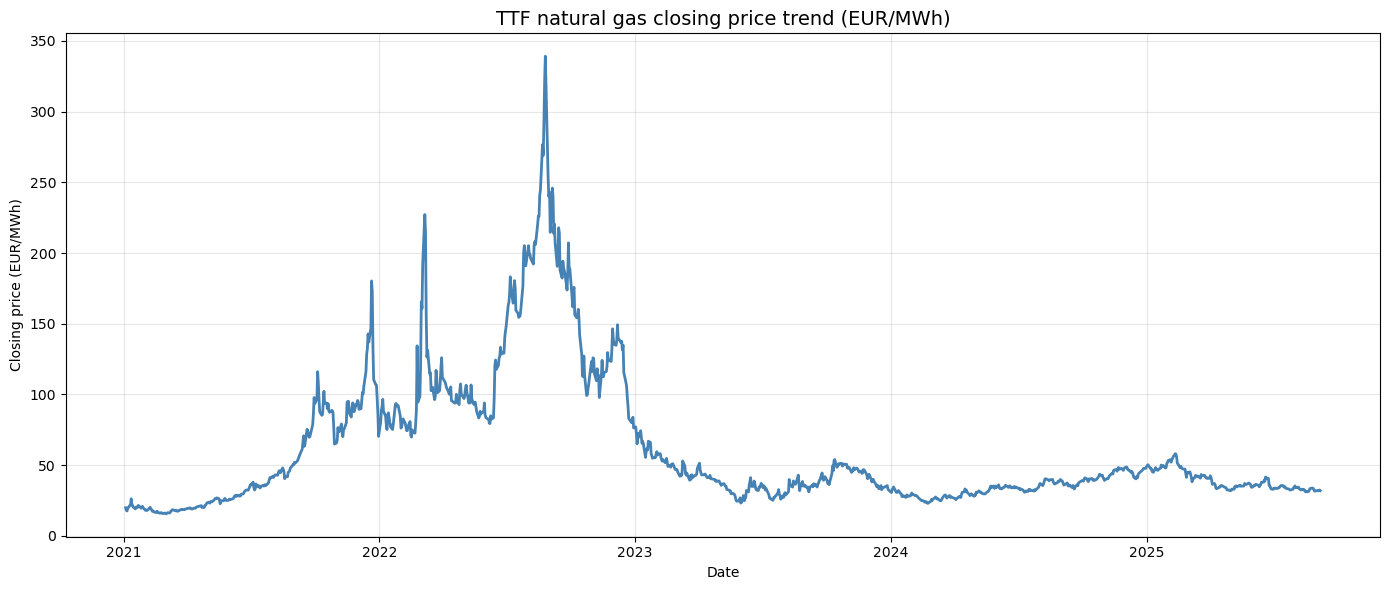

In [7]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], color='steelblue', linewidth=2)
plt.title('TTF natural gas closing price trend (EUR/MWh)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Closing price (EUR/MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

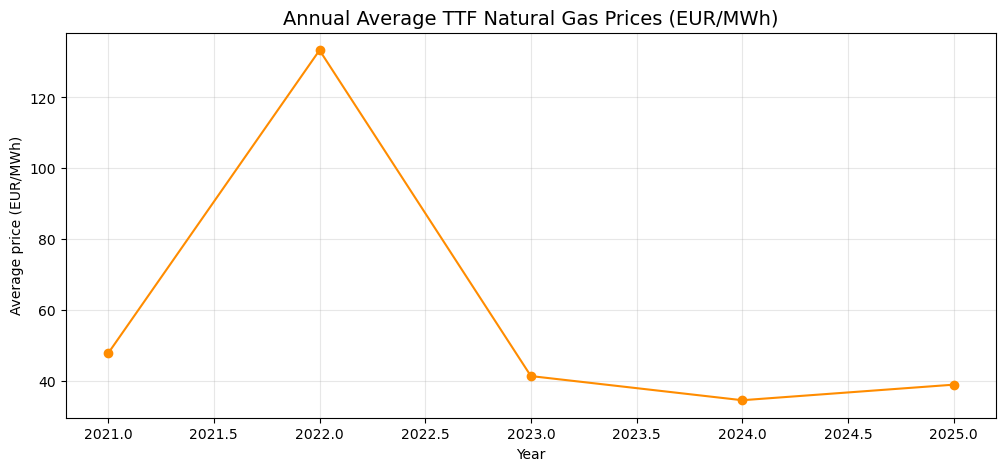

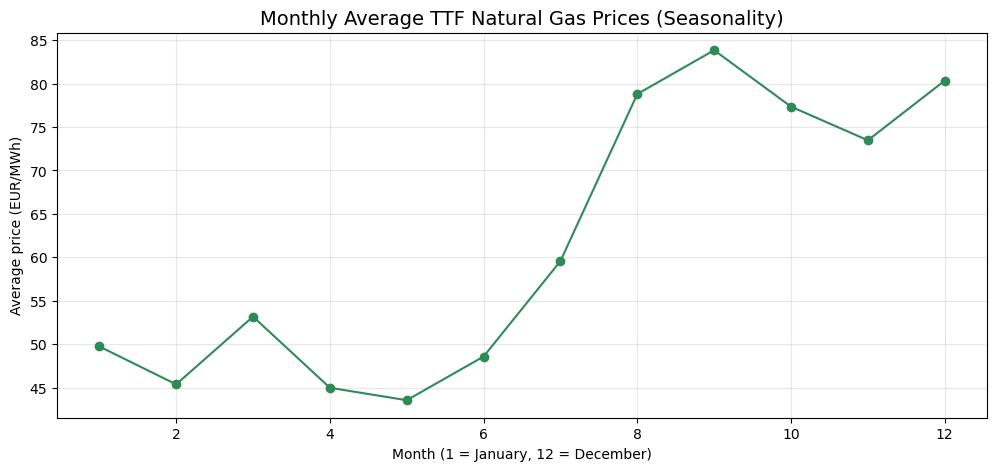

(   Year       Close
 0  2021   47.846252
 1  2022  133.319268
 2  2023   41.411086
 3  2024   34.600642
 4  2025   38.987011,
    Month      Close
 0      1  49.753850
 1      2  45.395762
 2      3  53.183427
 3      4  45.002202
 4      5  43.569144)

In [14]:
# Extracting year and month from the date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Annual average prices
yearly_avg = df.groupby('Year')['Close'].mean().reset_index()

# Monthly average prices
monthly_avg = df.groupby('Month')['Close'].mean().reset_index()

# Chart: Annual trend
plt.figure(figsize=(12,5))
plt.plot(yearly_avg['Year'], yearly_avg['Close'], marker='o', color='darkorange')
plt.title('Annual Average TTF Natural Gas Prices (EUR/MWh)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average price (EUR/MWh)')
plt.grid(True, alpha=0.3)
plt.show()

# Chart: Monthly seasonality
plt.figure(figsize=(12,5))
plt.plot(monthly_avg['Month'], monthly_avg['Close'], marker='o', color='seagreen')
plt.title('Monthly Average TTF Natural Gas Prices (Seasonality)', fontsize=14)
plt.xlabel('Month (1 = January, 12 = December)')
plt.ylabel('Average price (EUR/MWh)')
plt.grid(True, alpha=0.3)
plt.show()

yearly_avg, monthly_avg.head()

**Interpretation of trends and seasonality:**

Based on the annual averages, TTF natural gas prices drastically increased between 2021 and 2022, caused by the European energy crisis and geopolitical uncertainty. Since 2023, prices have gradually decreased, but they have still stabilized at a higher level than in the pre-crisis years.

Based on the monthly average prices, **seasonality can be observed**: Prices are typically higher during the winter months (November–February) due to increased heating demand; lower prices are observed during the summer months (May–August), when storage filling is underway and demand is more moderate.

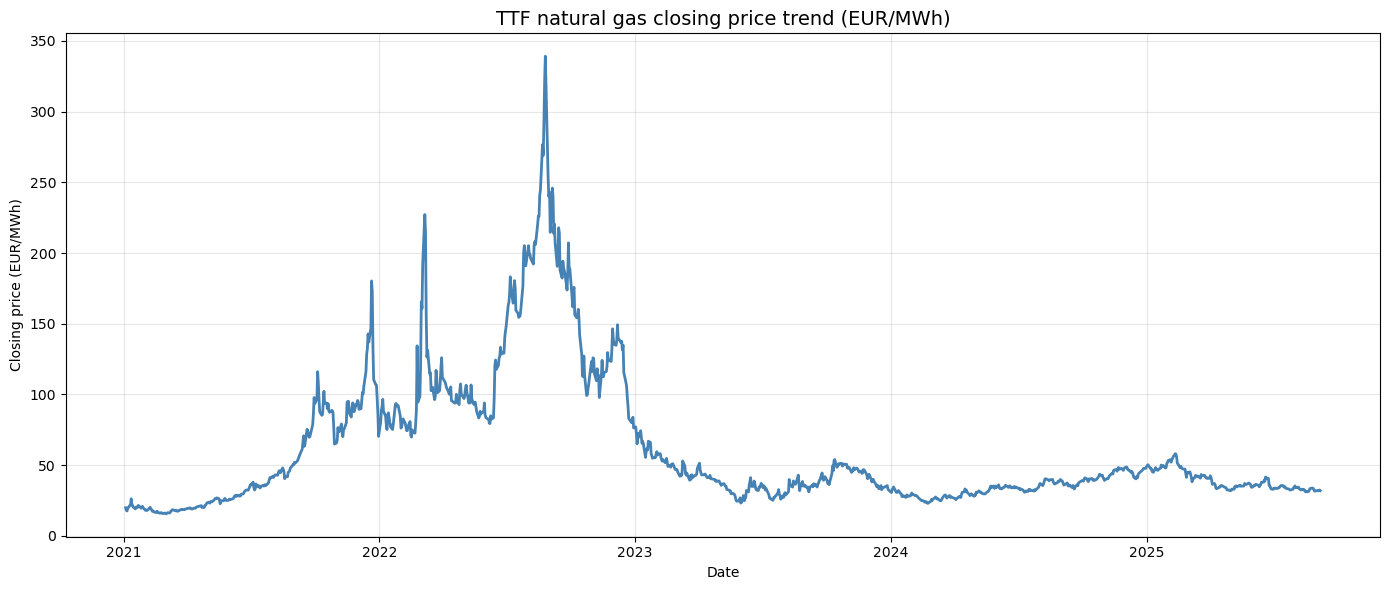

In [9]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], color='steelblue', linewidth=2)
plt.title('TTF natural gas closing price trend (EUR/MWh)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Closing price (EUR/MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

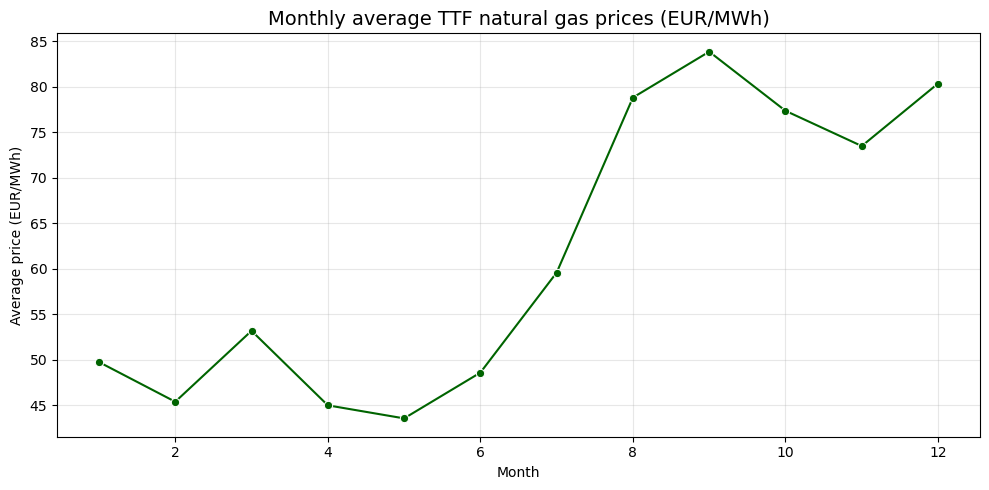

In [15]:
# Creating new columns to extract the year and month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Calculating monthly average prices
monthly_avg = df.groupby('Month')['Close'].mean().reset_index()

# Chart
plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_avg, x='Month', y='Close', color='darkgreen', marker='o')
plt.title('Monthly average TTF natural gas prices (EUR/MWh)', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Average price (EUR/MWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**My explanation:**
Based on the monthly averages, prices are typically higher during the winter months (December–February), while they are lower in the summer when demand decreases. This reflects the seasonality of natural gas consumption.

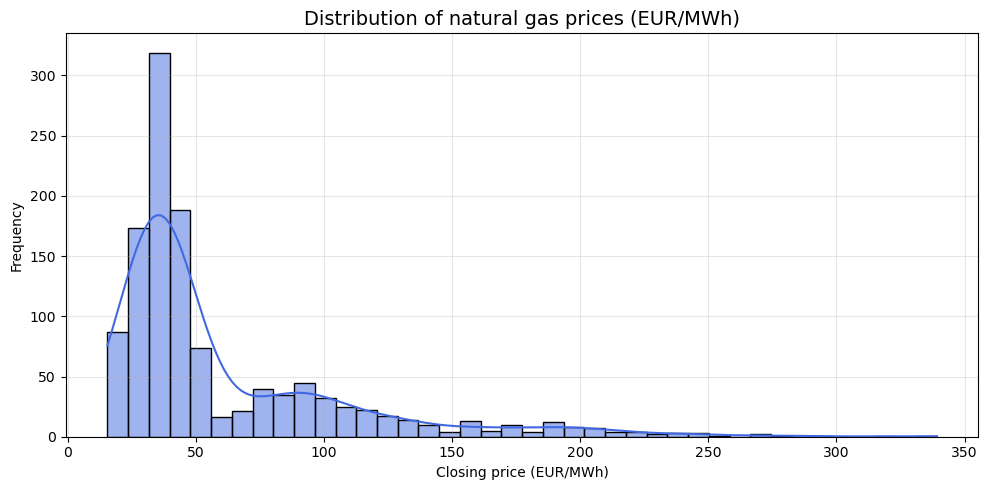

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(df['Close'], bins=40, kde=True, color='royalblue')
plt.title('Distribution of natural gas prices (EUR/MWh)', fontsize=14)
plt.xlabel('Closing price (EUR/MWh)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation of the chart above:**
The distribution is right-skewed, meaning most prices were between 20 and 80 EUR, but a few extreme outliers (the 2022 crisis period) pulled the average upwards.

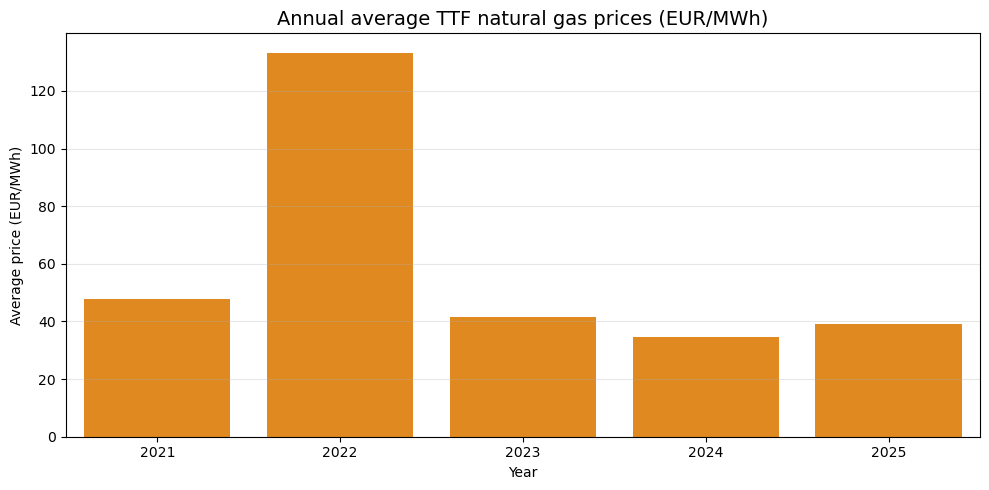

In [16]:
yearly_avg = df.groupby('Year')['Close'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=yearly_avg, x='Year', y='Close', color='darkorange')
plt.title('Annual average TTF natural gas prices (EUR/MWh)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average price (EUR/MWh)')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Interpretation of the bar chart above:**
Prices in 2022 were by far the highest—this is clearly a consequence of the market crisis and geopolitical events (e.g., the Russian-Ukrainian war).

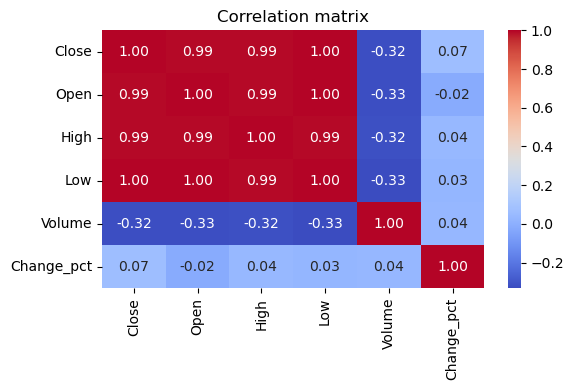

In [13]:
plt.figure(figsize=(6,4))
sns.heatmap(df[['Close','Open','High','Low','Volume','Change_pct']].corr(), 
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

My matrix above shows how closely the prices, volume, and daily change move together. The **Open**, **High**, **Low**, and **Close** columns are very strongly correlated with each other (close to 1.00).

However, **Volume** and **Change_pct** show a weaker correlation, which indicates market volatility.

**Business interpretation and conclusions:**

**A) Main trends and patterns in natural gas prices (2021–2025)**

TTF natural gas prices showed significant volatility during the analyzed period. **Up until 2021, the market was characterized by stable**, moderate price levels (20–40 EUR/MWh). This was followed by a **drastic price increase in 2022**, primarily triggered by geopolitical tensions, the reduction in Russian gas supplies, and market uncertainty. **Since 2023, a gradual price correction and stabilization have been observed**, but the price level still exceeds that of the pre-war period.

**Overall:** A slightly decreasing trend in the long term, with significant volatility still present in the short term.

**B) Conclusions regarding seasonality and storage strategy**

Clear **seasonality** is observed in the prices:

- **Winter months (December–February)** Prices rise due to increased heating demand.

- **Summer months (June–September)** Prices typically fall when demand drops and storage filling is underway.

**C) From a Portfolio Manager's perspective:**

- **Fill storage** in the summer,

- **Withdraw and sell** in the winter, as this strategy increases returns and mitigates price risk.

**D) Price outlook for Q4 2025**

Prices between 2023–2025 stabilized in the 30–60 EUR/MWh range. Based on current trends, a **moderate winter price increase** is expected in Q4 2025, but not to the extreme extent seen in 2022.

**Estimated price level:** 50–70 EUR/MWh, likely in the upper range due to seasonality.

**Main risks:** Supply disruption, extreme cold winter, or geopolitical tension.

**Summary:**

Based on my analysis, the TTF natural gas market experienced extreme price swings between 2021 and 2025, primarily shaped by geopolitical and demand factors. The market has gradually normalized since 2023 but remains sensitive to supply risks and seasonal effects.

**Business strategy recommendation:**

- **Storage** during low summer prices,

- **Selling** during high winter prices,

- Continuous **monitoring** of LNG supply and storage capacities is recommended.